## Fit DCE data

In [71]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import dce_fit, relaxivity, signal_models, water_ex_models, aifs, pk_models
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### First get the signal data

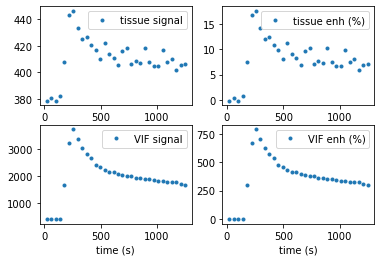

In [72]:
# Input time and signal values (subject 4)
t = np.array([19.810000,59.430000,99.050000,138.670000,178.290000,217.910000,257.530000,297.150000,336.770000,376.390000,416.010000,455.630000,495.250000,534.870000,574.490000,614.110000,653.730000,693.350000,732.970000,772.590000,812.210000,851.830000,891.450000,931.070000,970.690000,1010.310000,1049.930000,1089.550000,1129.170000,1168.790000,1208.410000,1248.030000])
s_vif = np.array([411.400000,420.200000,419.600000,399.000000,1650.400000,3229.200000,3716.200000,3375.600000,3022.000000,2801.200000,2669.800000,2413.800000,2321.400000,2231.400000,2152.800000,2138.200000,2059.200000,2037.600000,2008.200000,1998.800000,1936.800000,1939.400000,1887.000000,1872.800000,1840.200000,1820.400000,1796.200000,1773.000000,1775.600000,1762.000000,1693.400000,1675.800000])
s_tissue = np.array([378.774277,380.712810,378.789773,382.467975,407.950413,443.482955,446.239153,433.392045,425.428202,426.274793,420.676653,417.144112,410.072831,422.042355,414.013430,410.885847,405.251033,415.864669,418.615186,406.327479,408.692149,406.797004,418.646694,408.176136,404.993285,405.098140,417.022211,408.189050,409.819731,401.988636,405.866219,406.299587])

# Calculate the enhancement
baseline_idx = [0, 1, 2]
enh_vif = dce_fit.sig_to_enh(s_vif, baseline_idx)
enh_tissue = dce_fit.sig_to_enh(s_tissue, baseline_idx)

fig, ax = plt.subplots(2,2)
ax[0,0].plot(t, s_tissue, '.', label='tissue signal')
ax[1,0].plot(t, s_vif, '.', label='VIF signal')
ax[1,0].set_xlabel('time (s)');
ax[0,1].plot(t, enh_tissue, '.', label='tissue enh (%)')
ax[1,1].plot(t, enh_vif, '.', label='VIF enh (%)')
ax[1,1].set_xlabel('time (s)');
[a.legend() for a in ax.flatten()];


### Convert enhancement to concentration

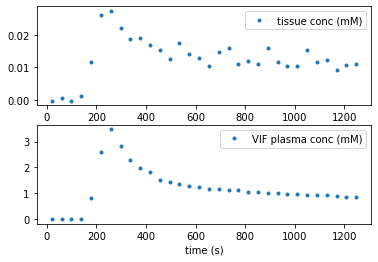

In [14]:
# First define some relevant parameters
R10_tissue, R10_vif = 1/1.3651, 1/1.7206
k_vif, k_tissue = 0.9946, 1.2037 # flip angle correction factor
hct = 0.46

# Specify relaxivity model, i.e. concentration --> relaxation rate relationship
c_to_r_model = relaxivity.c_to_r_linear(r1=5.0, r2=7.1)

# Specify signal model, i.e. relaxation rate --> signal relationship
signal_model = signal_models.spgr(tr=3.4e-3, fa_rad=15.*(np.pi/180.), te=1.7e-3)

# Calculate concentrations
C_t = dce_fit.enh_to_conc(enh_tissue, k_tissue, R10_tissue, c_to_r_model, signal_model)
c_p_vif = dce_fit.enh_to_conc(enh_vif, k_vif, R10_vif, c_to_r_model, signal_model) / (1-hct)

fig, ax = plt.subplots(2,1)
ax[0].plot(t, C_t, '.', label='tissue conc (mM)')
ax[0].set_xlabel('time (s)');
ax[1].plot(t, c_p_vif, '.', label='VIF plasma conc (mM)')
ax[1].set_xlabel('time (s)');
[a.legend() for a in ax.flatten()];

### Fit the concentration data using a pharmacokinetic model

Wall time: 7.2 ms
Fitted parameters: {'vp': 0.008094484920365339, 'ps': 0.00020001817008106877}
Expected: vp = 0.0081, ps = 2.00e-4


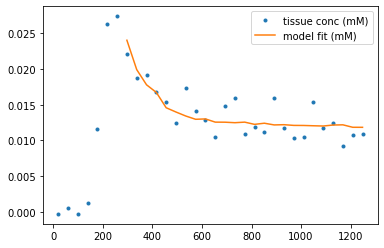

In [64]:
# First create an AIF object
aif = aifs.patient_specific(t, c_p_vif)

# Now create a pharmacokinetic model object
pk_model = pk_models.patlak(t, aif)

# Set some initial parameters and fit the concentration data
weights = np.concatenate([np.zeros(7), np.ones(25)]) # (exclude first few points from fit)
pk_pars_0 = [{'vp': 0.2, 'ps': 1e-4}] # (just use 1 set of starting parameters here)

%time pk_pars, C_t_fit = dce_fit.conc_to_pkp(C_t, pk_model, pk_pars_0, weights)

plt.plot(t, C_t, '.', label='tissue conc (mM)')
plt.plot(t, C_t_fit, '-', label='model fit (mM)')
plt.legend();

print(f"Fitted parameters: {pk_pars}")
print(f"Expected: vp = 0.0081, ps = 2.00e-4")

### Alternative approach: fit the tissue signal directly
To do this, we also need to create a water_ex_model object, which determines the relationship between R1 in each tissue compartment and the exponential R1 components.  
We start by assuming the fast water exchange limit (as implicitly assumed above when estimating tissue concentration).
The result should be very similar to fitting the concentration curve.

Wall time: 8.74 ms
Fitted parameters: {'vp': 0.008081261804746866, 'ps': 0.00019935670547333183}
Expected: vp = 0.0081, ps = 2.00e-4


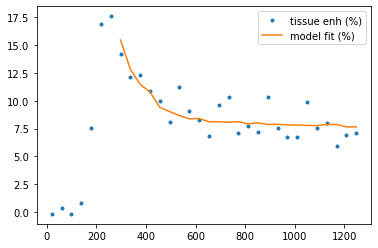

In [73]:
# Create a water exchange model object.
water_ex_model = water_ex_models.fxl()

# Now fit the enhancement curve
%time pk_pars_enh, enh_fit = dce_fit.enh_to_pkp(enh_tissue, hct, k_tissue, R10_tissue, R10_vif, pk_model, c_to_r_model, water_ex_model, signal_model, pk_pars_0, weights)

plt.plot(t, enh_tissue, '.', label='tissue enh (%)')
plt.plot(t, enh_fit, '-', label='model fit (%)')
plt.legend();

print(f"Fitted parameters: {pk_pars_enh}")
print(f"Expected: vp = 0.0081, ps = 2.00e-4")

### Repeat the fit assuming slow water exchange...
This time, we assume slow water exchange across the vessel wall. The result will be very different compared with fitting the concentration curve.

Wall time: 166 ms
Fitted parameters: {'vp': 0.011282424728448814, 'ps': 0.00011163566464040331}
Expected: vp = 0.0113, ps = 1.12e-4


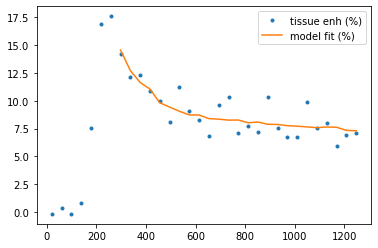

In [6]:
# Create a water exchange model object.
water_ex_model = water_ex_models.ntexl() # slow exchange across vessel wall, fast exchange across cell wall

# Now fit the enhancement curve
%time pk_pars_enh_ntexl, enh_fit_ntexl = dce_fit.enh_to_pkp(enh_tissue, hct, k_tissue, R10_tissue, R10_vif, pk_model, c_to_r_model, water_ex_model, signal_model, pk_pars_0, weights)

plt.plot(t, enh_tissue, '.', label='tissue enh (%)')
plt.plot(t, enh_fit_ntexl, '-', label='model fit (%)')
plt.legend();

print(f"Fitted parameters: {pk_pars_enh_ntexl}")
print(f"Expected: vp = 0.0113, ps = 1.12e-4")